# Next steps

- Better extraction of scada nomenclature
- Use of word embeddings
- Include features in other columns

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import dimension
import glob
import pathlib
from collections import OrderedDict
import re
import string
from numpy import argmax

# Functions

In [2]:
def clean_text(text):
    """
    Takes text and cleans
    
    :param str text: Text
    :return: Cleaned text
    """
    # text_nonum = re.sub(r'\d+', '', text)  # remove numbers
    text_nonum = " ".join(s for s in text.split() if not any(c.isdigit() for c in s))  # remove words with any digits
    text_split_upper = re.sub(r'((?<=[a-z])[A-Z]|(?<!\A)[A-Z](?=[a-z]))', r' \1', text_nonum)  # use regex to separate words with spaces then split
    text_nopunct = "".join([char.lower() for char in text_split_upper if char not in string.punctuation])  # remove punctuation and convert character to lower case
    text_no_doublespace = re.sub("\s+", " ", text_nopunct).strip()  # substitue multiple whitespace for single. Remove leading and trailing whitespace
    text_no_single = " ".join([w for w in text_no_doublespace.split() if len(w)>2])
    return text_no_single


def preprocess(label_df, scada_df):
    """
    Preprocesses data ready for vectorization
    
    :param label_df: Labelled dataframe
    :param scada_df: Dataframe from scada
    :return: Processed dataframe
    """
    # Prepare dictionary matching description and egu to tag
    desc_dict = scada_df.set_index('TAG').to_dict()['DESCRIPTION']
    egu_dict = scada_df.set_index('TAG').to_dict()['EGU TAG']

    target_labels = ['tag_category', 'tag_subcategory', 'functional_area', 'process_area']

    df = label_df.copy()
    df['description'] = df['scada_tag'].apply(lambda x: desc_dict.get(x))  # map description
    df['egu'] = df['scada_tag'].apply(lambda x: egu_dict.get(x))  # map egu

    # clean features
    df.loc[:, ['sc_tag']] = df['scada_tag'].str.replace('_', ' ')
    df.loc[:, ['sc_tag']] = df['sc_tag'].fillna(' ')
    df.loc[:, ['desc']] = df['description'].str.replace("_", " ")
    df.loc[:, ['desc']] = df['desc'].fillna(' ')
    df.loc[:, ['egu']] = df['egu'].fillna(' ')

    # clean labels
    for label in target_labels:
        df.loc[:, [label]] = df[label].str.strip().replace(" ", "").str.title()

    # combine description features
    df.loc[:, ['clean_desc']] = df['sc_tag'] + ' ' + df['desc'] + ' ' + df['egu'].astype(str)
    df.loc[:, ['clean_desc']] = df['clean_desc'].str.strip()
    df = df[['scada_tag', 'description', 'egu', 'clean_desc', 'site_name', 'tag_category', 'tag_subcategory', 'functional_area', 'process_area']]

    # Fix label inconsistencies between sites
    df = df.replace({'1-Raw Water': '1-Raw Water Intake'})
    df = df.replace({'Rapid Gravity Filters': 'Rapid Gravity Filtration'})

    df['clean_desc'] = df['clean_desc'].str.replace("RGF", " RGF ")
    df['clean_desc'] = df['clean_desc'].str.replace("GAC", " GAC ")
    df['clean_desc'] = df['clean_desc'].apply(lambda x: clean_text(x))
    df['clean_desc'] = df['clean_desc'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')  # remove repeated
    
    ### these did not improve accuracy
    # df['clean_desc'] = df['clean_desc'].str.replace("rgf", "rapid gravity filter")
    # df['clean_desc'] = df['clean_desc'].str.replace("gac", "granular activated carbon")
    # df['clean_desc'] = df['clean_desc'].str.replace("daf", "dissolved air flotation")
    
    df = df[~df['site_name'].str.contains('0')]
    df = df.dropna(subset=target_labels)
    df = df.sort_values(by='site_name')
    df = df.reset_index(drop=True)
    return df


def run_vec(df):
    """
    Runs vectorization to generate word vectors
    
    :param df: Input dataframe
    :return: Dataframe with vector features concatanated
    """
    # no need to use idf since the text is already pretty sparse
    # sublinear tf scaling addresses the problem that 20 occurencs of a word is probably not 20 times more important than 1 occurence
    tfidf = TfidfVectorizer(use_idf=False)
    features = tfidf.fit_transform(df['clean_desc']).toarray()
    df = pd.concat([df, pd.DataFrame(features)], axis=1)
    return df
    

def generate_pred(X_train, y_train, X_test):
    """
    Generate predictions and probabilities using model
    
    :param X_train: Training features
    :param y_train: Training labels
    :param X_test: Testing features
    """
    model = RandomForestClassifier(n_estimators = 200, random_state=0)
    # svm = LinearSVC(random_state=0)
    # model = CalibratedClassifierCV(svm)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    return y_pred, y_proba


def generate_confusion(y_test, y_pred, annot_list, annot):
    """
    Generate confusion matrix and classification report
    
    :param y_test: Actual testing results
    :param y_pred: Predicted testing results
    :param annot_list: List of factorized target labels
    :param annot: True or false to show annotations on confusion matrix
    :return: Confusion matrix, classification report
    """
    conf_mat = confusion_matrix(y_test, y_pred)
    annotations = pd.DataFrame(conf_mat).astype(str).replace('0', '')

    fig, ax = plt.subplots(figsize=(15,12))
    if annot==True:
        sns.heatmap(conf_mat, annot=annotations, fmt='s', xticklabels=annot_list, yticklabels=annot_list)
    else:
        sns.heatmap(conf_mat, fmt='s')
    plt.ylabel('Actual', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Prediction of {target_label} - Accuracy={int(accuracy_score(y_test, y_pred)*100)}%. Test split={int(100*len(y_test)/(len(y_train)+len(y_test)))}%', fontweight='bold', pad=20)
    plt.show()
    print(metrics.classification_report(y_test, y_pred))
    
    
def mark_all_correct(df):
    """
    Makes a new column with 1 if all labels correct, 0 otherwise
    
    :param df: Result dataframe
    :return: New column with 1 if all correct
    """
    if (df['tag_category_correct']==1) and \
       (df['tag_subcategory_correct']==1) and \
       (df['functional_area_correct']==1) and \
       (df['process_area_correct']==1):
        return 1
    else:
        return 0

# Data ingestion

In [3]:
## Get Huby scada data
local_path = pathlib.Path(".").resolve()
huby_excel_file = list(local_path.glob("../data/YW_tags/WaterProd_HubyTags_Hal24KTrial_V3_AdamNLP.xlsx"))[0].resolve()
huby_scada_df = pd.read_excel(huby_excel_file, sheet_name="Huby-SCADATags", header=0, skiprows=[1], engine='openpyxl')

# Acomb scada data
acomb_excel_file = list(local_path.glob("../data/YW_tags/ACOMLDS1_CURRENT.xlsx"))[0].resolve()
acomb_scada_df = pd.read_excel(acomb_excel_file, sheet_name="ACOMLDS1_CURRENT", header=0, skiprows=[1], engine='openpyxl')

# Elvington scada data
elv_excel_file = list(local_path.glob("../data/YW_tags/ELVGTNS1_CURRENT.xlsx"))[0].resolve()
elv_scada_df = pd.read_excel(elv_excel_file, sheet_name="ELVGTNS1_CURRENT", header=0, skiprows=[1], engine='openpyxl')

# All 3 sites
all_scada_df = huby_scada_df[['TAG', 'DESCRIPTION']].append(acomb_scada_df[['TAG', 'DESCRIPTION']], ignore_index=True)
all_scada_df = all_scada_df.append(elv_scada_df[['TAG', 'DESCRIPTION', 'EGU TAG']], ignore_index=True)
all_scada_df = all_scada_df.reset_index(drop=True)

In [4]:
# Get labelled data

dim_sdk = dimension.Connect("../config.txt")
db = dim_sdk.db()
site_tags = db['site_tag_config']
cursor = site_tags.find({}, {"_id": 0,
                             "scada_tag": 1,
                             "site_name": 1,
                             "functional_area": 1, 
                             "process_area": 1, 
                             "tag_category": 1, 
                             "tag_subcategory": 1, 
                             "tag_name": 1,  
                             "common_reference": 1,
                             "is_alarm": 1
                             }
                         )
master_tag_data = list(cursor)
master_tag_dict = {tag_details.get("tag_name"): tag_details for tag_details in master_tag_data}
master_tag_df = pd.DataFrame(master_tag_data)
# site_tags.find_one()

# Labelled target data
huby_label_df = master_tag_df[master_tag_df['site_name']=='HUBY'].reset_index(drop=True)
acomb_label_df = master_tag_df[master_tag_df['site_name']=='ACOMB'].reset_index(drop=True)
elv_label_df = master_tag_df[master_tag_df['site_name']=='ELVINGTON'].reset_index(drop=True)
all_label_df = master_tag_df

Connecting to database.
Connection successful.


In [5]:
df_all = preprocess(all_label_df, all_scada_df)  # preprocess all data

In [6]:
df_feat = df_all['clean_desc']

In [7]:
df_lab = pd.get_dummies(df_all['functional_area'])

In [8]:
X = []
sentences = list(df_feat)
for sen in sentences:
    X.append(sen)

y = df_lab.values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('../glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(12, activation='sigmoid')(LSTM_Layer_1)  # number of labels in output
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [14]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          69400     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 188,196
Trainable params: 118,796
Non-trainable params: 69,400
_________________________________________________________________
None


In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [17]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
21/21 [==============================] - 16s 606ms/step - loss: 0.6027 - acc: 0.1112 - val_loss: 0.2547 - val_acc: 0.2293
Epoch 2/5
21/21 [==============================] - 10s 488ms/step - loss: 0.2517 - acc: 0.2151 - val_loss: 0.2452 - val_acc: 0.2293
Epoch 3/5
21/21 [==============================] - 14s 680ms/step - loss: 0.2485 - acc: 0.2302 - val_loss: 0.2439 - val_acc: 0.2293
Epoch 4/5
21/21 [==============================] - 11s 535ms/step - loss: 0.2473 - acc: 0.2178 - val_loss: 0.2433 - val_acc: 0.2262
Epoch 5/5
21/21 [==============================] - 11s 507ms/step - loss: 0.2492 - acc: 0.2017 - val_loss: 0.2463 - val_acc: 0.2293


In [18]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

26/26 [==============================] - 2s 64ms/step - loss: 0.2498 - acc: 0.1935
Test Score: 0.24977165460586548
Test Accuracy: 0.193508118391037


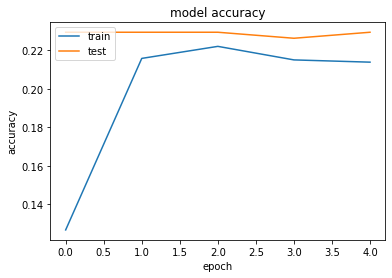

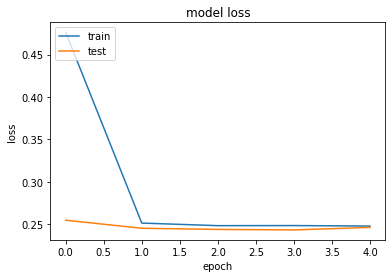

In [19]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()